# Pre-Processing

In [218]:
# General Libraries
from sklearn.cluster import KMeans
from matplotlib import colors
from matplotlib import cm
from PIL import Image
from sklearn.pipeline import make_pipeline
from IPython.display import HTML
from scipy.spatial.distance import euclidean, cityblock, cosine
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
import glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster

# Database Library
import sqlite3

# BoW-related Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')


pd.set_option('display.max_colwidth', 310)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2021/aamorado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [390]:
def diverge(mgw):
    def inner_diverge(word, font_size, position, orientation,
                      random_state=None, **kwargs):
        cmap = cm.get_cmap('coolwarm_r')
        norm = colors.Normalize(
            vmin=mgw.min(),
            vmax=mgw.max()+0.01)
        r, g, b, a = cmap(norm(mgw[word]))
        color = np.array([255*r, 255*g, 255*b])
        return tuple(color.astype(int))
    return inner_diverge


def sv2wc(sv, feature_names, components, mask_path):
    allorder = np.argsort(np.abs(components[:, sv-1]))
    woerds = [feature_names[o] for o in allorder]
    weghts = components[allorder, sv-1]
    mga_words = pd.Series(weghts, index=woerds)

    # Generate a word cloud image
    mask = np.array(Image.open(mask_path))
    font = 'Roboto-Regular.ttf'
    wordcloud = WordCloud(
        background_color=None,
        mode='RGBA',
#         width=3840, height=2160,
        width=800, height=600,
#         max_words=500,
#         min_font_size=8,
        font_path=font,
        relative_scaling=1,
#         mask=mask,
        color_func=diverge(mga_words),
    ).generate_from_frequencies(np.abs(mga_words))

    # Display the image
#     plt.subplots(figsize=(20, 12), dpi=140)
    plt.subplots(figsize=(10, 8), dpi=90)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud of  SV{sv}', fontsize=16, fontweight='black')
    plt.axis("off")
    plt.show()


def cluster_cloud(words, y, rnd):
    ks = np.unique(y)
    mask = np.array(Image.open('anon1.png'))
    font = 'Roboto-Regular.ttf'
    for k in ks:
        idx = [i for i, x in enumerate(y) if x == k]
        wordcloud = WordCloud(
            background_color='black',
            width=800, height=600,
            max_words=5000,
            min_font_size=8,
            font_path=font,
            random_state=rnd,
            mask=mask,
            stopwords=sw_all + ['looking'],
            relative_scaling=0.50,
            colormap='autumn',
        ).generate(' '.join([words[i].lower() for i in idx]))
        # Display the image
        plt.subplots(figsize=(12, 8), dpi=96)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'WordCloud of Cluster {k}',
                  fontsize=16, fontweight='black')
        plt.axis('off')
        plt.show()


def cluster_k_cloud(words, y, k, mask_path, rs=0.5, rnd=1337):
    ks = np.unique(y)
    mask = np.array(Image.open(mask_path))
    font = 'Roboto-Regular.ttf'
    idx = [i for i, x in enumerate(y) if x == k]
    wordcloud = WordCloud(
        background_color=None,
        mode='RGBA',
        width=2160, height=3840,
        max_words=5000,
        min_font_size=8,
        font_path=font,
        relative_scaling=rs,
        random_state=rnd,
        mask=mask,
        stopwords=sw_all + ['looking'],
        colormap='autumn',
    ).generate(' '.join([words[i].lower() for i in idx]))
    # Display the image
    plt.subplots(figsize=(12, 20), dpi=140)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud of Cluster {k}',
              fontsize=16, fontweight='black')
    plt.axis('off')
    plt.show()


def top_ics(rows, cols, features, components):
    fig, ax = plt.subplots(
        nrows=rows, ncols=cols,
        figsize=(4*cols, 4+rows*2), sharex=True)
    for i, ax in enumerate(ax.flat):
        rank = np.argsort(np.abs(components[:, i]))[-10:]
        ax.barh(
            [features[r] for r in rank],
            components[rank, i])
        ax.set_title(f'SV{i+1}')
    fig.suptitle('Top 20 Topics Uncovered',
                 fontsize=16, fontweight='black', y=.9)
    fig.show()

In [ ]:
# Import Data
raw_posts = pd.read_csv('1597299442_post_data_dump.csv', engine='python')
raw_users = pd.read_csv('1597299442_user_data_dump.csv', engine='python')

In [ ]:
# Drop first column
raw_posts = raw_posts.drop(
    columns=[raw_posts.columns[0]]+['time_scraped'], axis=1)
raw_users = raw_users.drop(
    columns=[raw_users.columns[0]]+['time_scraped'], axis=1)

In [ ]:
# Data Extraction Functions

def get_post_id(s):
    """Extract post id"""
    m = re.search('Ad ID: (\d+)', s)
    return int(m.group(1))


def get_message_age(s):
    """Extract any age indications from text."""
    m = re.search('(?:^|\W)'  # Line start or Non-numeric
                  '(\d{2})'  # 2-digit age
                  'y'        # y for year?
                  , s)
    try:
        m.group(1)
    except AttributeError:
        return np.nan
    else:
        return int(m.group(1))


def get_username(s):
    """Extract username."""
    return str(s).split("\n")[0]


def get_parsed_address(s):
    """Extract available parts of address."""
    m = re.search(r'([.0-9]+)\s([.0-9]+)(?:(\s[.0-9]+\s)|\s)(\w+)\W+(\w+)', s)
    return (float(m.group(1)),
            float(m.group(2)),
            int(m.group(3)) if m.group(3) else np.nan,
            m.group(4).strip(),
            m.group(5).strip())


def get_title_age(s):
    """Get (title,age) from title_age"""
    s_split = s.split('â€“')
    if len(s_split) == 2:
        try:
            int(s_split[1])
        except ValueError:
            return s_split[0], np.nan
        else:
            return s_split[0], int(s_split[1])
    else:
        return s_split[0], np.nan


def get_when_registered_cat(s):
    """Extract when_registration category"""
    m = re.search('\d\+ \w+ ago', s)
    try:
        m.group(0)
    except AttributeError:
        return ''
    else:
        return m.group(0)


def get_when_registered_url(s):
    """Extract when_registration url"""
    m = re.search('(http.*)$', s)
    try:
        m.group(0)
    except AttributeError:
        return ''
    else:
        return m.group(0)


def get_userinfo_review(s):
    """Extract review aspect of user_info"""
    m = re.search(r'\(.*?review.*?\)', str(s), re.IGNORECASE)
    try:
        m.group(0)
    except AttributeError:
        return ''
    else:
        if m:
            return m.group(0)
        else:
            return ''


def get_userinfo_addresses(s):
    """Extract addresses aspect of user_info"""
    m = re.search(
        r'^([,a-zA-Z]+)(?:$| \n|((?: |\n)Phone\nverified))', str(s), re.IGNORECASE)
    if m:
        return m.group(1)
    else:
        return ''

In [ ]:
# Transform Raw Posts Data
df_posts = raw_posts.copy()
df_posts['post_id'] = df_posts['post_id'].apply(get_post_id)
df_posts['message_age'] = df_posts['message'].apply(get_message_age)
df_posts['post_username'] = df_posts['post_username'].apply(get_username)
df_posts['post_title'], df_posts['post_user_age'] = zip(
    *df_posts['title_age'].apply(get_title_age))
df_posts['address'] = df_posts['address'].apply(lambda x: x.replace('\n', ' '))
df_posts['longitude'], df_posts['latitude'], df_posts['zip_code'], df_posts['address'], df_posts['country'] = zip(
    *df_posts.address.apply(get_parsed_address))
df_posts['categories'] = df_posts['categories'].apply(
    lambda x: x.replace('\n', ' '))

# Delete Columns Not to be Used
del df_posts['title_age']

# Delete Row with No Username
df_posts = df_posts[df_posts['post_username'] != 'nan'].reset_index()

# DataFrame Preview
df_posts.head(3)

In [ ]:
# Transform Raw Users Data
df_users = raw_users.copy()
df_users['username'] = df_users['username'].apply(get_username)
df_users['user_verified'] = df_users['user_info'].apply(
    lambda x: 1 if 'Phone\nverified' in str(x) else 0)
df_users['user_review'] = df_users['user_info'].apply(get_userinfo_review)

# Extract Address From user_info through cleaning
df_users['user_addresses'] = ''
for i, data in df_users[['user_info', 'user_review']].iterrows():
    cleansed_user_info = (str(data['user_info'])
                          .replace(data['user_review'], '')
                          .replace('Phone\nverified', '')
                          .replace('\n', ' ')
                          .replace('nan', '')
                          .strip())
    df_users.loc[i, 'user_addresses'] = cleansed_user_info

df_users['when_registered_cat'] = df_users['when_registered'].apply(
    get_when_registered_cat)
df_users['when_registered_url'] = df_users['when_registered'].apply(
    get_when_registered_url)

# Delete columns not to be used
del df_users['user_info']
del df_users['when_registered']

# DataFrame Preview
df_users.head(3)

Issues:
* raw_users (*user_info*): Was only able to extract info on reviews, phone verifications, addresses
* raw_users (*when_registered*): contains links also (but extracted as well)

In [ ]:
# Drop Duplicates for Posts and Users Data
df_posts = df_posts.drop_duplicates().reset_index(drop=True)
df_users = df_users.drop_duplicates().reset_index(drop=True)

# Output to Database

In [ ]:
df_posts

In [ ]:
# Store in DB
if len(df_posts.post_username.unique()) == len(df_users.username.unique()):
    df_posts.to_sql('posts', con=sqlite3.connect(
        'locanto.db'), index=False, if_exists='replace')
    df_users.to_sql('users', con=sqlite3.connect(
        'locanto.db'), index=False, if_exists='replace')
else:
    raise ValueError("May naligaw na user. Tingnang mabuti. Salamat.")

# Vectorize

In [393]:
# Import Posts Data from Database
with sqlite3.connect('locanto.db') as conn:
    df = pd.read_sql(
        """
        SELECT *
        FROM posts
        INNER JOIN users ON posts.post_username = users.username
        """,
        conn
    )


df

index  \
0         0   
1         1   
2         2   
3         3   
4         4   
...     ...   
5186   5217   
5187   5218   
5188   5219   
5189   5220   
5190   5221   

                                                                                                          url  \
0                                                   https://caloocan.locanto.ph/ID_4431741164/CUM-SQUIRT.html   
1                                                  https://caloocan.locanto.ph/ID_4431741365/Sweet-pussy.html   
2                                               https://caloocan.locanto.ph/ID_4431741458/Real-Cum-Eater.html   
3                                              https://caloocan.locanto.ph/ID_4431741554/Cum-in-my-Mouth.html   
4                                           https://manila.locanto.ph/ID_4428795045/looking-right-now-20.html   
...                                                                                                       ...   
5186  https://quezoncity.locanto.ph/ID_1659361528/a-couple-looking-for-a-couple-in-manila-or-surrounding.html   
5187           https://caloocan.locanto.ph/ID_1561193163/Discreet-mixed-couple-seeking-couple-for-LTR-35.html   
5188                                                  https://manila.locanto.ph/ID_1371815668/Couple-sex.html   
5189                                      https://cebu.locanto.ph/ID_1259904269/Im-looking-for-3-some-45.html   
5190                                                   https://cebu.locanto.ph/ID_1188789296/we-love-sex.html   

         post_id  \
0     4431741164   
1     4431741365   
2     4431741458   
3     4431741554   
4     4428795045   
...          ...   
5186  1659361528   
5187  1561193163   
5188  1371815668   
5189  1259904269   
5190  1188789296   

                                                                                                                                                                                                                                                                                                                    message  \
0                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
1                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
2                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
3                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
4                                                                                                                                                                                                                           looking for right now who want to chill and im on the way agad to your room? chill and netflix?   
...                                                                                                                                                                                                                                                                                                                     .

In [395]:
df[['message']]

message
0                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927
1                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927
2                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927
3                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927
4                                                                                                                                                                                                                           looking for right now who want to chill and im on the way agad to your room? chill and netflix?
...                                                                                                                                                                                                                                                                                                                     ...
5186  Hi ... I am 37, my name is Ali and i am from UAE but living in manila with my filipina wife . looking for a relationship with a bbw, or a couple who is interested in swinging and swapping. RESPECT is an important factor in anybody's life so we follow that rule and expect the same from others, Any interest...
5187  Hello we are a mixes couple American /Pilipino seeking another couple for a long term relationship. We do have requirement 1. Couple must be hygienic 2. Couple must be discreet\n3. Couple must be professional and \n4. Couple must be seeking a LTR \nIf you meet these requirements feel free to contact us. W...
5188                                                                                                                                                                                                 No swapping of partners pero pwede touch touch , gusto lang namin ma try yung may couple din na nagsesex , taft avenue
5189                                                                                                                                                                                                                                                                                      fuck fuck fuck fuck 3 some 4 some
5190                                                                                                                                                                              im kurt ngo looking a couple for fun ......try me 0942 nine four seven 2020.....for free free free free free free we love sex we love sex

[5191 rows x 1 columns]

In [396]:
wordfrq = dict(zip(bow_message['columns'], bow_message['data'].sum(axis=0)))
for key, value in wordfrq.items():
    if 'looking' in key:
        wordfrq[key] = 0

In [397]:
wordcloud = WordCloud(
    background_color=None,
    mode='RGBA',
    width=2160, height=3840,
    max_words=5000,
    min_font_size=8,
    font_path='Roboto-Regular.ttf',
#     random_state=1337,
#     relative_scaling=1,
    mask=np.array(Image.open('anon1.png')),
    stopwords=sw_all + ['looking', 'message', 'Looking', "i'm"],
    colormap='autumn_r',
).generate(' '.join(df.message.str.lower().unique()))
# ).generate_from_frequencies(wordfrq)
    
# Display the image
plt.subplots(figsize=(16, 20), dpi=140)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'WordCloud of All Posts',
          fontsize=16, fontweight='black')
plt.axis('off')
plt.show()

KeyboardInterrupt: 

## Messages

### Try changing the `TF-IDF` vectorizer parameters for the messages here to capture more, less or other targetted phrases.

In [398]:
sw_foreign = [
    'baiknya', 'berkali', 'kali',
    'kurangnya', 'mata', 'olah',
    'printr', 'sekurang', 'setidak',
    'tama', 'tidaknya', 'onların', 'δι',
    'агар-чи', 'аз-баски', 'афташ', 'бале', 'баҳри',
    'болои', 'валекин', 'вақте', 'вуҷуди', 'гар', 'гарчанде',
    'даме', 'карда', 'кошки', 'куя', 'кӣ', 'магар', 'майлаш',
    'модоме', 'нияти', 'онан', 'оре', 'рӯи', 'сар', 'тразе',
    'хом', 'хуб', 'чаро', 'чи', 'чунон', 'шарте', 'қадар',
    'ҳай-ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳой-ҳой', 'ҳол',
    'ҳолате', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर',
    'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद',
    'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम',
    'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन',
    'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल',
    'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत',
    'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष',
    'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत',
    'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर',
    'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक',
    'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन',
    'हर', 'हरण', 'ἀλλ']

sw_foreign += [
    'acaba', 'ace', 'aceast', 'aib', 'ais', 'altm', 'amos', 'aras', 'arr',
    'art', 'asl', 'ave', 'avr', 'azut', 'b', 'bamos', 'ban', 'baz', 'bb',
    'bel', 'ber', 'birka', 'bizl', 'br', 'bunlar', 'dac', 'dana', 'dant',
    'dou', 'dup', 'dur', 'dvain', 'ega', 'eiv', 'ejo', 'elel', 'elela',
    'elele', 'eleli', 'elelo', 'elen', 'elena', 'elene', 'eleni', 'eleno',
    'eleti', 'eli', 'elijo', 'elim', 'elimo', 'elita', 'elite', 'eliva',
    'els', 'emer', 'emerkoli', 'emo', 'emu', 'emur', 'emurkoli', 'enkoli',
    'eprav', 'eravno', 'ere', 'erega', 'erem', 'eremu', 'erih', 'erim',
    'erima', 'erimi', 'esar', 'esarkoli', 'estdeset', 'estdeseta', 
    'estdesete', 'estdesetega', 'estdesetem', 'estdesetemu', 'estdeseti',
    'estdesetih', 'estdesetim', 'estdesetima', 'estdesetimi', 'estdeseto',
    'estega', 'estem', 'estemu', 'esti', 'estih', 'estim', 'estima', 'estimi',
    'estindvajset', 'estindvajsetih', 'estindvajsetim', 'estindvajsetimi',
    'estintrideset', 'estintridesetih', 'estintridesetim', 'estintridesetimi',
    'estiv', 'estnajst', 'estnajsta', 'estnajste', 'estnajstega', 'estnajstem',
    'estnajstemu', 'estnajsti', 'estnajstih', 'estnajstim', 'estnajstima',
    'estnajstimi', 'estnajsto', 'eststo', 'eststotih', 'eststotim', 
    'eststotimi', 'estuvi', 'eta', 'ete', 'etm', 'etrta', 'etrte', 'etrtega',
    'etrtem', 'etrtemu', 'etrti', 'etrtih', 'etrtim', 'etrtima', 'etrtimi',
    'etrto', 'etudi', 'eva', 'ey', 'ezenj', 'eznje', 'f', 'far', 'fr', 'g',
    'gil', 'gon', 'gra', 'gy', 'habr', 'haqq', 'heid', 'heill',
    'heilt', 'heiss', 'heist', 'heit', 'hi', 'hj', 'houv', 'hrend', 'hubi',
    'hv', 'hz', 'iden', 'ie', 'igar', 'igav', 'igava', 'igave', 'igavega',
    'igavem', 'igavemu', 'igavi', 'igavih', 'igavim', 'igavima', 'igavimi',
    'igavo', 'ih', 'ihin', 'iksi', 'ild', 'ille', 'ilt', 'ima', 'imer',
    'imerkoli', 'ina', 'ine', 'ism', 'iss', 'istifad', 'jabb', 'jra', 'kakr',
    'keill', 'keilt', 'keiss', 'keist', 'keit', 'kenell', 'kenelt', 'keness',
    'kenest', 'keress', 'kereszt', 'ket', 'ketk', 'kkiz', 'kone', 'ks', 'ksi',
    'lb', 'lea', 'lk', 'lle', 'lli', 'lt', 'ltal', 'lv',
    'marsi', 'marve', 'meid', 'meill', 'meilt', 'meiss', 'meist', 'meit',
    'mik', 'mill', 'milt', 'mitk', 'mo', 'mul',
    'najbr', 'nakoli', 'namre', 'nd', 'nda', 'neen', 'nega', 'negakoli', 
    'nekoli', 'nelt', 'nemkoli', 'nemu', 'nemukoli', 'nen', 'ness', 'nest', 
    'net', 'nhamos', 'nih', 'nihkoli', 'niill', 'niilt', 'niiss', 
    'niist', 'niit', 'nikakr', 'nikoli', 'nim', 'nima', 'nimakoli', 'nimi',
    'nimikoli', 'nimkoli', 'nin', 'niy', 'nk', 'nki', 'nn', 'nnen', 'nnte',
    'noastr', 'nokoli', 'nt', 'ny', 'og', 'ogs', 'olmad', 'olmu', 'oric',
    'osemin', 'ox', 'p', 'perch', 'petin', 'pi', 'ppen', 'pu', 'q', 'qar',
    'qiq', 'r', 'ra', 'rd', 'rde', 'rden', 'rei', 'ret', 'ror', 'rt', 'rui', 
    'rx', 'sad', 'saniy', 'sar', 'sedemin', 'sek', 'semos', 'ser', 'siin',
    'siit', 'sik', 'sill', 'silt', 'sizl', 'sj', 'slind', 'spri', 'ss',
    'ssemos', 'ssze', 'st', 'star', 'stea', 'sunte', 'sz', 'taient', 'tais',
    'tait', 'tal', 'tamb', 'tambi', 'tant', 'tante', 'tantes', 'tants',
    'teid', 'teill', 'teilt', 'teiss', 'teist', 'teit', 'temve', 'ten', 
    'tendr', 'teng', 'tia', 'tiez', 'tions', 'tiri', 'tirideset',
    'tirideseta', 'tiridesete', 'tiridesetega', 'tiridesetem', 'tiridesetemu',
    'tirideseti', 'tiridesetih', 'tiridesetim', 'tiridesetima', 
    'tiridesetimi', 'tirideseto', 'tirih', 'tiriindvajset', 'tiriindvajseta',
    'tiriindvajsete', 'tiriindvajsetega', 'tiriindvajsetem', 
    'tiriindvajsetemu', 'tiriindvajseti', 'tiriindvajsetih',
    'tiriindvajsetim', 'tiriindvajsetima', 'tiriindvajsetimi', 
    'tiriindvajseto', 'tirim', 'tirimi', 'tirinajst', 'tirinajsta',
    'tirinajste', 'tirinajstega', 'tirinajstem', 'tirinajstemu', 'tirinajsti',
    'tirinajstih', 'tirinajstim', 'tirinajstima', 'tirinajstimi', 
    'tirinajsto', 'tiristo', 'tiristotih', 'tiristotim', 'tiristotimi', 
    'tirje', 'tiso', 'tiv', 'toat', 'totu', 'tov', 'tre', 'tric', 'triin',
    'tt', 'tuot', 'tuvi', 'tva', 'utols', 'val', 'vamos', 'varf', 'ver', 
    'vnovi', 'vo', 'voastr', 'voc', 'vou', 'vpri', 'vsakr', 'vzdol', 'w',
    'yaln', 'yax', 'yen', 'yetmi', 'zmo']

with open('stopwords_tagalog.txt') as f:
    sw_tg = f.read().split() + ['lang']

sw_all = stopwords.words() + sw_foreign + sw_tg + ['looking']


def to_bow(x, col_name, min_df=0.001, max_df=0.800, ngram_range=(1, 3),
           token_pattern=r'(?u)\b(\w(?:\w|\-)+)\b'):
    """Return BOW of words given column"""
    tfidf_vectorizer = TfidfVectorizer(
        token_pattern=token_pattern,
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram_range,
        stop_words=sw_all
    )
    vec = tfidf_vectorizer.fit_transform(x[col_name].fillna(''))
    return {
        'data': vec.toarray(),
        'columns': tfidf_vectorizer.get_feature_names()
    }

### Change the `n_components` to reach the 90% VE, which will automatically compute for the required components `n_comp`

In [399]:
# Get unique messages
df_message = (df['message']
              .value_counts()
              .rename_axis('message')
              .reset_index(name='counts'))
display(df_message)

message  \
0                                                                                                                                                                                                   A real Young Hot Gorgeous Sexy Ts A Total Package One with a fully functional cock and a tight ass from top to bottom..   
1     i am a single mom,Looking for someone to sex with me.I live alone and have my own car so I can travel if needed.want a good fuck totally free,\nI do not want money. If you Real & interested,, Age no problem….\n\n\nAny available time today or tomorrow… If you are interested,\n\nText me : mayamom.889 G mQai...   
2                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
3     i am a single mom,Looking for someone to sex with me.I live alone and have my own car so I can travel if needed.want a good fuck totally free,\nI do not want money. If you Real & interested,, Age no problem….\n\nAccording to locantoo rules i can't write down my email address completely.(G mQail)..\n\nMess...   
4     i am a single mom,Looking for someone to sex with me.I live alone and have my own car so I can travel if needed.want a good fuck totally free,\nI do not want money. If you Real & interested,, Age no problem….\n\nAccording to locantoo rules i can't write down my email address completly.(G mQail)..\n\nMessa...   
...                                                                                                                                                                                                                                                                                                                     ...   
4427                                                                                                                                                                                                                                  My husband and I wanted to explore with another couple. Anyone interested message me.   
4428                                                                                                                                                                    Hi guys! I'm rhea and I'm new here! I want to meet new people here! Hope you will be kind to entertain me! Add me in WhatsApp or Viber 09672910255.   
4429                                                                                                                                                                                                                   im looking for girl kung san ka komportable inuman watch movie or any more sometging just contact me   
4430                                                                                                                                                                                                                                                   Looking for Fubu preferably with girl. No to boys. \nBtw I'm a butch   
4431                                                                                                                  Male here, Looking for LADIES, good companion, non smoker and most of all discreet and clean. 29yrs old below. Looking for someone to have fun with. Either one time or fubu pag nagkasundo. QC Only.   

      counts  
0         25  
1         25  
2         24  
3         24  
4         24  
...      ...  
4427       1  
4428       1  
4429       1  
4430       1  
4431       1  

[4432 rows x 2 columns]

In [400]:
bow_message = to_bow(df_message, 'message')

In [401]:
pd.DataFrame(**bow_message)

00966572309551  09051737763  09054324510  09062648841  09064593568  \
0                0.0          0.0          0.0          0.0          0.0   
1                0.0          0.0          0.0          0.0          0.0   
2                0.0          0.0          0.0          0.0          0.0   
3                0.0          0.0          0.0          0.0          0.0   
4                0.0          0.0          0.0          0.0          0.0   
...              ...          ...          ...          ...          ...   
4427             0.0          0.0          0.0          0.0          0.0   
4428             0.0          0.0          0.0          0.0          0.0   
4429             0.0          0.0          0.0          0.0          0.0   
4430             0.0          0.0          0.0          0.0          0.0   
4431             0.0          0.0          0.0          0.0          0.0   

      09369488768  09398019085  09436108098  09561854699  09563619267  ...  \
0             0.0          0.0          0.0          0.0          0.0  ...   
1             0.0          0.0          0.0          0.0          0.0  ...   
2             0.0          0.0          0.0          0.0          0.0  ...   
3             0.0          0.0          0.0          0.0          0.0  ...   
4             0.0          0.0          0.0          0.0          0.0  ...   
...           ...          ...          ...          ...          ...  ...   
4427          0.0          0.0          0.0          0.0          0.0  ...   
4428          0.0          0.0          0.0          0.0          0.0  ...   
4429          0.0          0.0          0.0          0.0          0.0  ...   
4430          0.0          0.0          0.0          0.0          0.0  ...   
4431          0.0          0.0          0.0          0.0          0.0  ...   

      yung  yung pwede  zero  zero five  zero nine  zero nine five  \
0      0.0         0.0   0.0        0.0        0.0             0.0   
1      0.0         0.0   0.0        0.0        0.0             0.0   
2      0.0         0.0   0.0        0.0        0.0             0.0   
3      0.0         0.0   0.0        0.0        0.0             0.0   
4      0.0         0.0   0.0        0.0        0.0             0.0   
...    ...         ...   ...        ...        ...             ...   
4427   0.0         0.0   0.0        0.0        0.0             0.0   
4428   0.0         0.0   0.0        0.0        0.0             0.0   
4429   0.0         0.0   0.0        0.0        0.0             0.0   
4430   0.0         0.0   0.0        0.0        0.0             0.0   
4431   0.0         0.0   0.0        0.0        0.0             0.0   

      zero nine six  zero nine two  zero seven  zoey  
0               0.0            0.0         0.0   0.0  
1               0.0            0.0         0.0   0.0  
2               0.0            0.0         0.0   0.0  
3               0.0            0.0         0.0   0.0  
4               0.0            0.0         0.0   0.0  
...             ...            ...         ...   ...  
4427            0.0            0.0         0.0   0.0  
4428            0.0            0.0         0.0   0.0  
4429            0.0            0.0         0.0   0.0  
4430            0.0            0.0         0.0   0.0  
4431            0.0            0.0         0.0   0.0  

[4432 rows x 3446 columns]

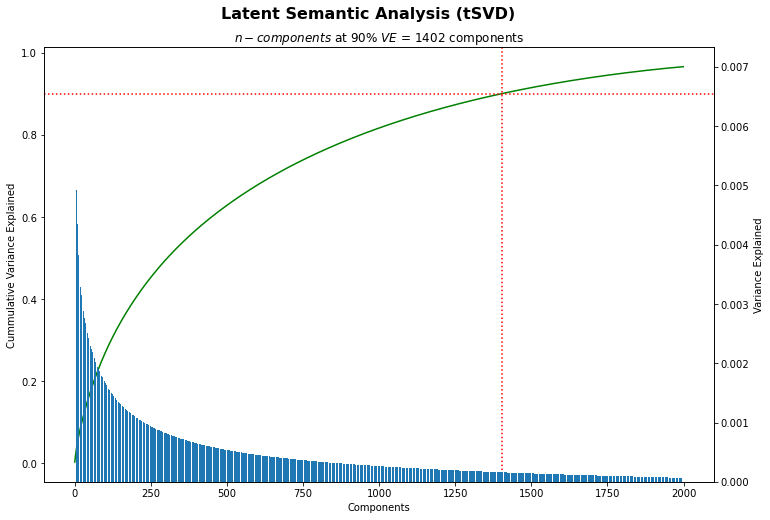

In [70]:
bow_message = to_bow(df_message, 'message')

lsa = TruncatedSVD(
    n_components=2000,
    random_state=1337)
lsa.fit(bow_message['data'])

n_comp = np.argmax(lsa.explained_variance_ratio_.cumsum() > 0.90) + 1

# Plot
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)
ax2 = ax.twinx()
ax.plot(
    lsa.explained_variance_ratio_.cumsum(),
    '-g',
    label='Cummulative')
ax2.bar(
    range(len(lsa.explained_variance_ratio_)),
    lsa.explained_variance_ratio_,
    label='Individual')
ax.set_xlabel('Components')
ax.set_ylabel('Cummulative Variance Explained')
ax2.set_ylabel('Variance Explained')
ax.set_title(f'$n-components$ at $90\%$ $VE$ = ${n_comp}$ components')
ax.axhline(0.9, ls=':', c='r')
ax.axvline([np.nan, n_comp][bool(n_comp)], ls=':', c='r')
fig.suptitle('Latent Semantic Analysis (tSVD)',
             y=.95, fontsize=16, fontweight='black')
fig.show()

In [71]:
pd.DataFrame(**bow_message)

00966572309551  09051737763  09054324510  09062648841  09064593568  \
0                0.0          0.0          0.0          0.0          0.0   
1                0.0          0.0          0.0          0.0          0.0   
2                0.0          0.0          0.0          0.0          0.0   
3                0.0          0.0          0.0          0.0          0.0   
4                0.0          0.0          0.0          0.0          0.0   
...              ...          ...          ...          ...          ...   
4427             0.0          0.0          0.0          0.0          0.0   
4428             0.0          0.0          0.0          0.0          0.0   
4429             0.0          0.0          0.0          0.0          0.0   
4430             0.0          0.0          0.0          0.0          0.0   
4431             0.0          0.0          0.0          0.0          0.0   

      09369488768  09398019085  09436108098  09561854699  09563619267  ...  \
0             0.0          0.0          0.0          0.0          0.0  ...   
1             0.0          0.0          0.0          0.0          0.0  ...   
2             0.0          0.0          0.0          0.0          0.0  ...   
3             0.0          0.0          0.0          0.0          0.0  ...   
4             0.0          0.0          0.0          0.0          0.0  ...   
...           ...          ...          ...          ...          ...  ...   
4427          0.0          0.0          0.0          0.0          0.0  ...   
4428          0.0          0.0          0.0          0.0          0.0  ...   
4429          0.0          0.0          0.0          0.0          0.0  ...   
4430          0.0          0.0          0.0          0.0          0.0  ...   
4431          0.0          0.0          0.0          0.0          0.0  ...   

      yung  yung pwede  zero  zero five  zero nine  zero nine five  \
0      0.0         0.0   0.0        0.0        0.0             0.0   
1      0.0         0.0   0.0        0.0        0.0             0.0   
2      0.0         0.0   0.0        0.0        0.0             0.0   
3      0.0         0.0   0.0        0.0        0.0             0.0   
4      0.0         0.0   0.0        0.0        0.0             0.0   
...    ...         ...   ...        ...        ...             ...   
4427   0.0         0.0   0.0        0.0        0.0             0.0   
4428   0.0         0.0   0.0        0.0        0.0             0.0   
4429   0.0         0.0   0.0        0.0        0.0             0.0   
4430   0.0         0.0   0.0        0.0        0.0             0.0   
4431   0.0         0.0   0.0        0.0        0.0             0.0   

      zero nine six  zero nine two  zero seven  zoey  
0               0.0            0.0         0.0   0.0  
1               0.0            0.0         0.0   0.0  
2               0.0            0.0         0.0   0.0  
3               0.0            0.0         0.0   0.0  
4               0.0            0.0         0.0   0.0  
...             ...            ...         ...   ...  
4427            0.0            0.0         0.0   0.0  
4428            0.0            0.0         0.0   0.0  
4429            0.0            0.0         0.0   0.0  
4430            0.0            0.0         0.0   0.0  
4431            0.0            0.0         0.0   0.0  

[4432 rows x 3639 columns]

In [72]:
lsa.set_params(n_components=n_comp)
bow_message['lsa'] = lsa.fit_transform(bow_message['data'])
bow_message['components'] = lsa.components_.T

In [402]:
bow_message['lsa'].shape

KeyError: 'lsa'

### Change the `nrows`, `ncols` and `figsize` to view more SV's.

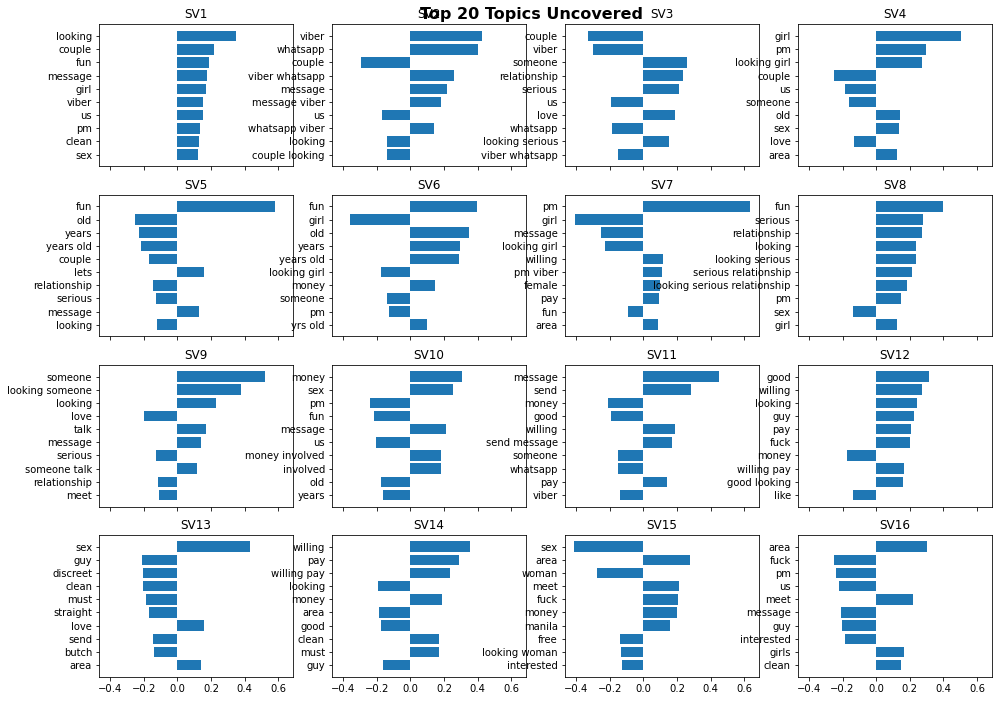

In [389]:
# Checkout top topics
top_ics(4, 4, bow_message['columns'], bow_message['components'])

### Create Wordcloud for a selected `SV` number (check above)

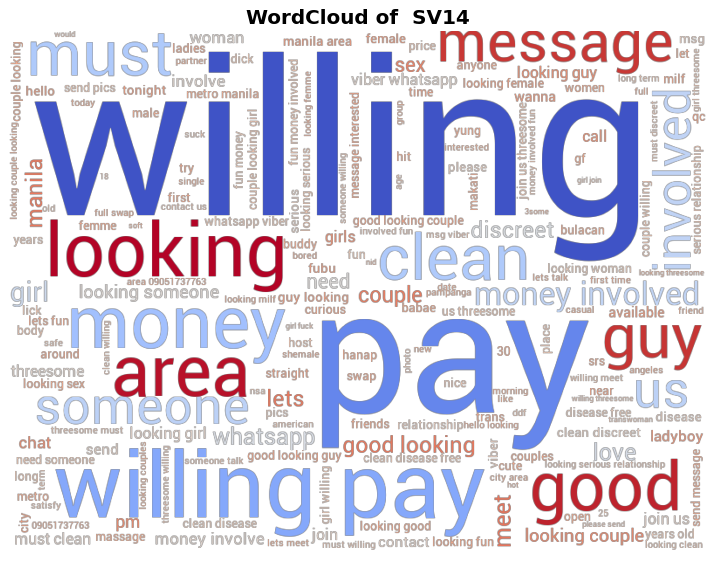

In [391]:
# Checkout WC of SV
sv2wc(
    14, bow_message['columns'],
    bow_message['components'],
    'clouds.png')

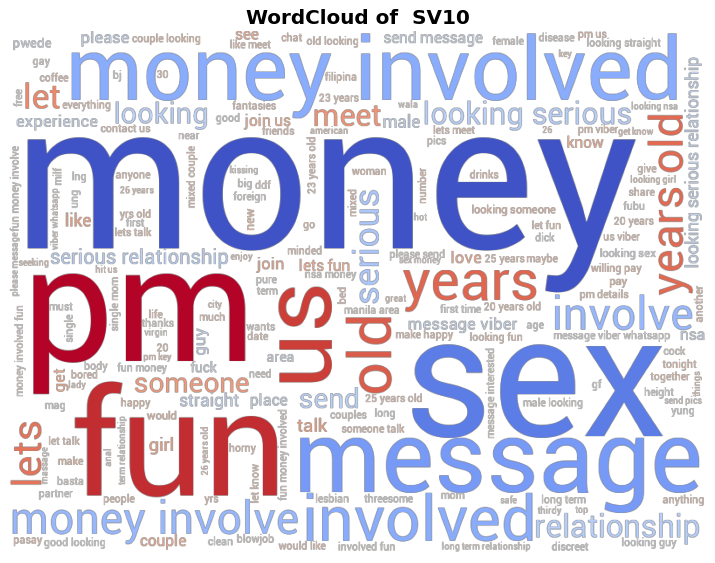

In [392]:
# Checkout WC of SV
sv2wc(
    10, bow_message['columns'],
    bow_message['components'],
    'cloud.jpg')

## Titles

### Change the `n_components` to reach the 90% VE, which will automatically compute for the required components `n_comp`

In [76]:
df_title = (df['post_title']
            .value_counts()
            .rename_axis('title')
            .reset_index(name='counts'))
display(df_title)

title  \
0                                                          Wild on bed – 25   
1                                          I want guapo str8 guys – 38 – 38   
2                                     Looking for serious relationship – 29   
3             Gay guy lookin for pamilyadong married pinoys/foreigners – 26   
4     Gay guy lookin/naghahanap ng pamilyadong married pinoys/foreigne – 26   
...                                                                     ...   
5078                                   One night stand for female only – 20   
5079                                      Youngest Goos Ts Pinay Asian – 23   
5080        Need Woman for Vlog Collaboration 30 mins streaming decent – 28   
5081                                                     Suck my Boobs – 22   
5082                                 Just landed in ph ladyboy fantasy – 26   

      counts  
0          6  
1          5  
2          4  
3          3  
4          3  
...      ...  
5078       1  
5079       1  
5080       1  
5081       1  
5082       1  

[5083 rows x 2 columns]

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['got', 'legal', 'mag', 'mink', 'miss', 'mist', 'ok', 'ramos', 'tall'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(5083, 729)


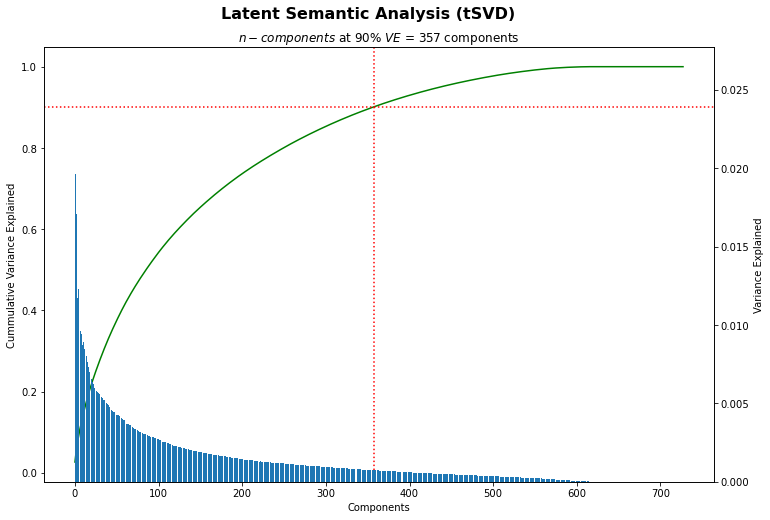

In [77]:
bow_title = to_bow(
    df_title,
    'title',
    token_pattern=r'[a-z]+',
    ngram_range=(1, 3),
    max_df=1.0)

lsa = TruncatedSVD(
    n_components=len(bow_title['columns'])-1,
    random_state=1337)
lsa.fit(bow_title['data'])

n_comp = np.argmax(lsa.explained_variance_ratio_.cumsum() > 0.90) + 1

# Plot
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)
ax2 = ax.twinx()
ax.plot(
    lsa.explained_variance_ratio_.cumsum(),
    '-g',
    label='Cummulative')
ax2.bar(
    range(len(lsa.explained_variance_ratio_)),
    lsa.explained_variance_ratio_,
    label='Individual')
ax.set_xlabel('Components')
ax.set_ylabel('Cummulative Variance Explained')
ax2.set_ylabel('Variance Explained')
ax.set_title(f'$n-components$ at $90\%$ $VE$ = ${n_comp}$ components')
ax.axhline(0.9, ls=':', c='r')
ax.axvline([np.nan, n_comp][bool(n_comp)], ls=':', c='r')
fig.suptitle('Latent Semantic Analysis (tSVD)',
             y=.95, fontsize=16, fontweight='black')
fig.show()

In [78]:
pd.DataFrame(**bow_title)

action  adventure  adventurous  age  ages  alone  alone house  \
0        0.0        0.0          0.0  0.0   0.0    0.0          0.0   
1        0.0        0.0          0.0  0.0   0.0    0.0          0.0   
2        0.0        0.0          0.0  0.0   0.0    0.0          0.0   
3        0.0        0.0          0.0  0.0   0.0    0.0          0.0   
4        0.0        0.0          0.0  0.0   0.0    0.0          0.0   
...      ...        ...          ...  ...   ...    ...          ...   
5078     0.0        0.0          0.0  0.0   0.0    0.0          0.0   
5079     0.0        0.0          0.0  0.0   0.0    0.0          0.0   
5080     0.0        0.0          0.0  0.0   0.0    0.0          0.0   
5081     0.0        0.0          0.0  0.0   0.0    0.0          0.0   
5082     0.0        0.0          0.0  0.0   0.0    0.0          0.0   

      alone house join  alone mom  alone mom searching  ...  young  \
0                  0.0        0.0                  0.0  ...    0.0   
1                  0.0        0.0                  0.0  ...    0.0   
2                  0.0        0.0                  0.0  ...    0.0   
3                  0.0        0.0                  0.0  ...    0.0   
4                  0.0        0.0                  0.0  ...    0.0   
...                ...        ...                  ...  ...    ...   
5078               0.0        0.0                  0.0  ...    0.0   
5079               0.0        0.0                  0.0  ...    0.0   
5080               0.0        0.0                  0.0  ...    0.0   
5081               0.0        0.0                  0.0  ...    0.0   
5082               0.0        0.0                  0.0  ...    0.0   

      young couple  young mom  young mom looking  youngest   yr  yr old  yrs  \
0              0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
1              0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
2              0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
3              0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
4              0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
...            ...        ...                ...       ...  ...     ...  ...   
5078           0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
5079           0.0        0.0                0.0  0.456122  0.0     0.0  0.0   
5080           0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
5081           0.0        0.0                0.0  0.000000  0.0     0.0  0.0   
5082           0.0        0.0                0.0  0.000000  0.0     0.0  0.0   

      yrs old  yrs old looking  
0         0.0              0.0  
1         0.0              0.0  
2         0.0              0.0  
3         0.0              0.0  
4         0.0              0.0  
...       ...              ...  
5078      0.0              0.0  
5079      0.0              0.0  
5080      0.0              0.0  
5081      0.0              0.0  
5082      0.0              0.0  

[5083 rows x 729 columns]

In [79]:
lsa.set_params(n_components=n_comp)
bow_title['lsa'] = lsa.fit_transform(bow_title['data'])
bow_title['components'] = lsa.components_.T

### Change the `nrows`, `ncols` and `figsize` to view more SV's.

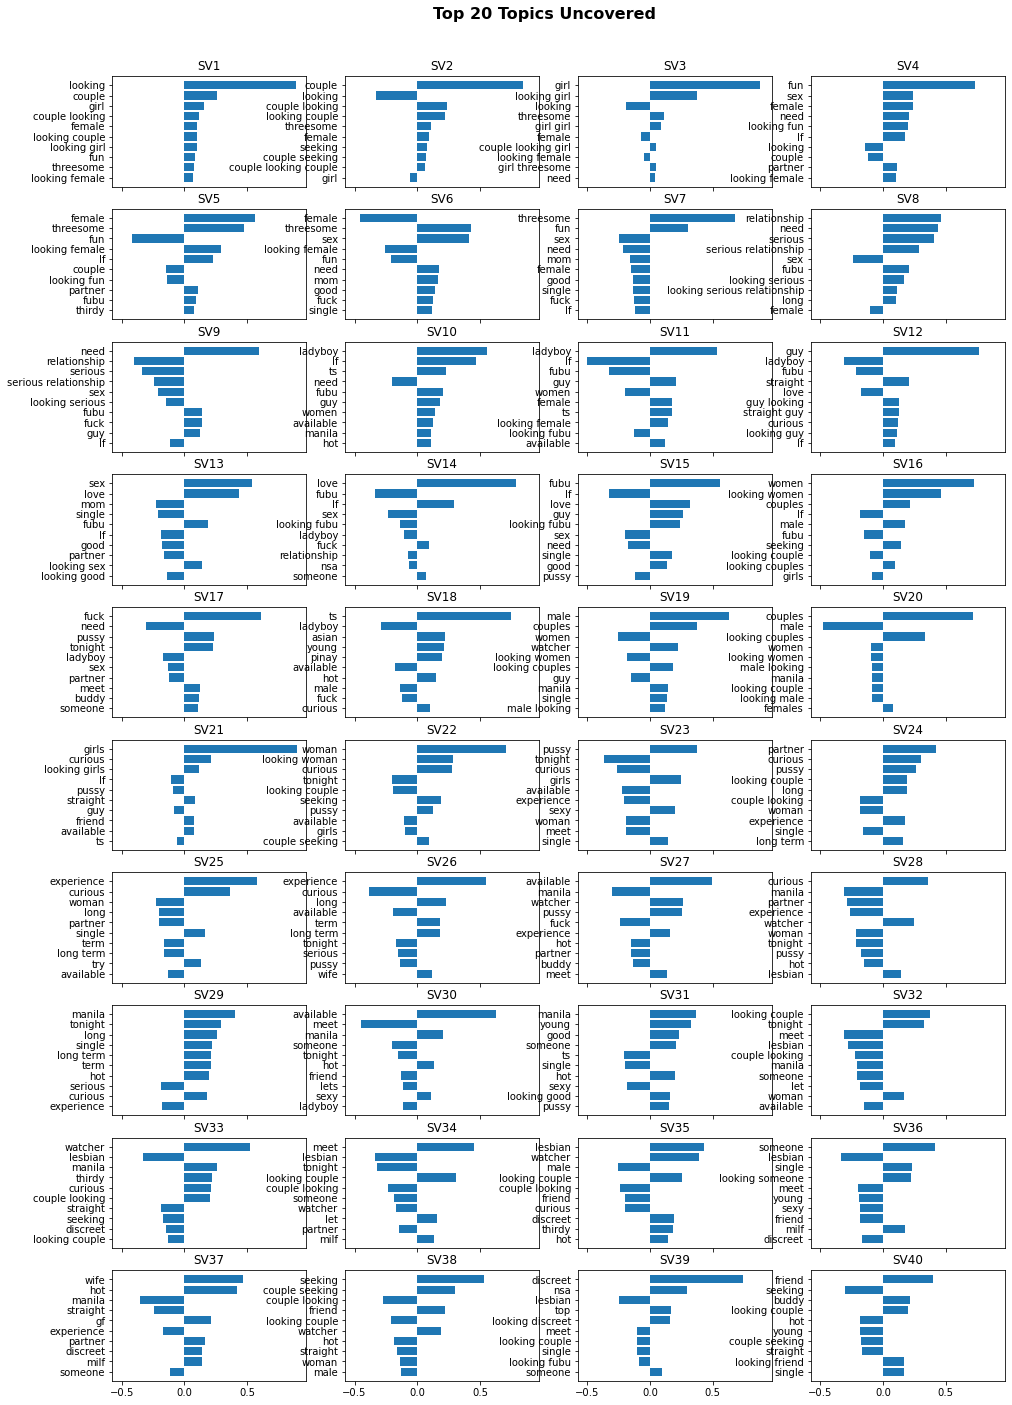

In [80]:
fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(16, 24), sharex=True)
for i, ax in enumerate(ax.flat):
    rank = np.argsort(np.abs(bow_title['components'][:, i]))[-10:]
    ax.barh(
        [bow_title['columns'][r] for r in rank],
        bow_title['components'][rank, i])
    ax.set_title(f'SV{i+1}')
fig.suptitle('Top 20 Topics Uncovered',
             fontsize=16, fontweight='black', y=.92)
fig.show()

### Create Wordcloud for a selected `SV` number (check above)

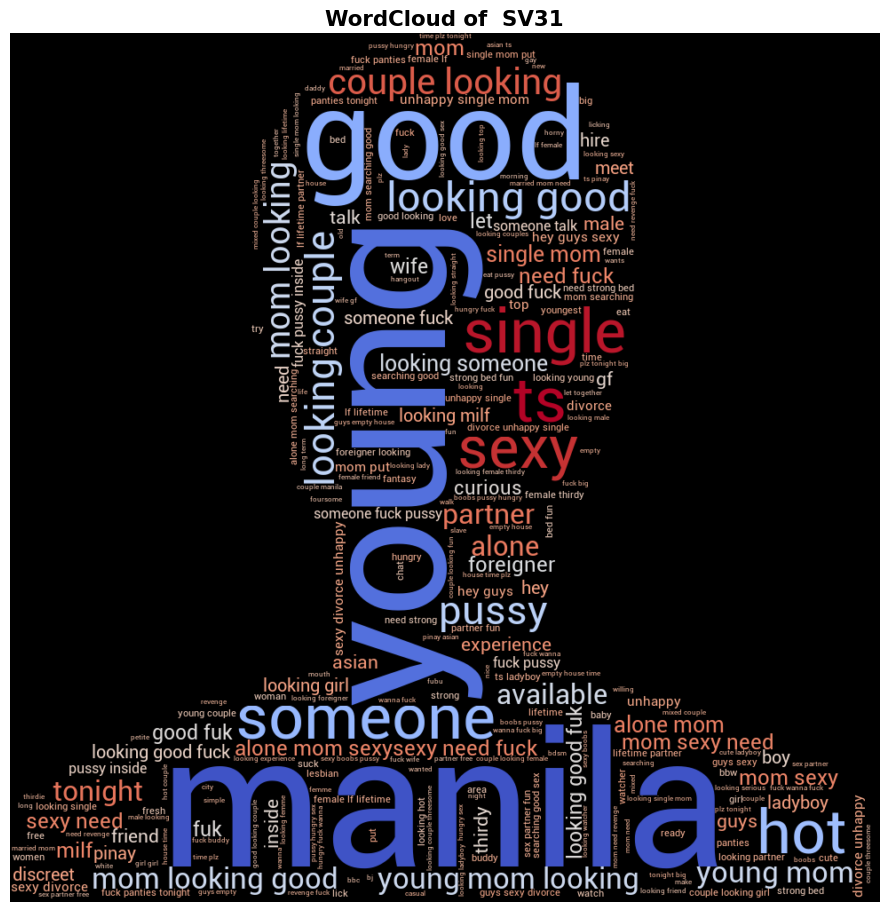

In [81]:
# Checkout WC of SV
sv2wc(31, bow_title['columns'], bow_title['components'])

# Cluster

## Messages

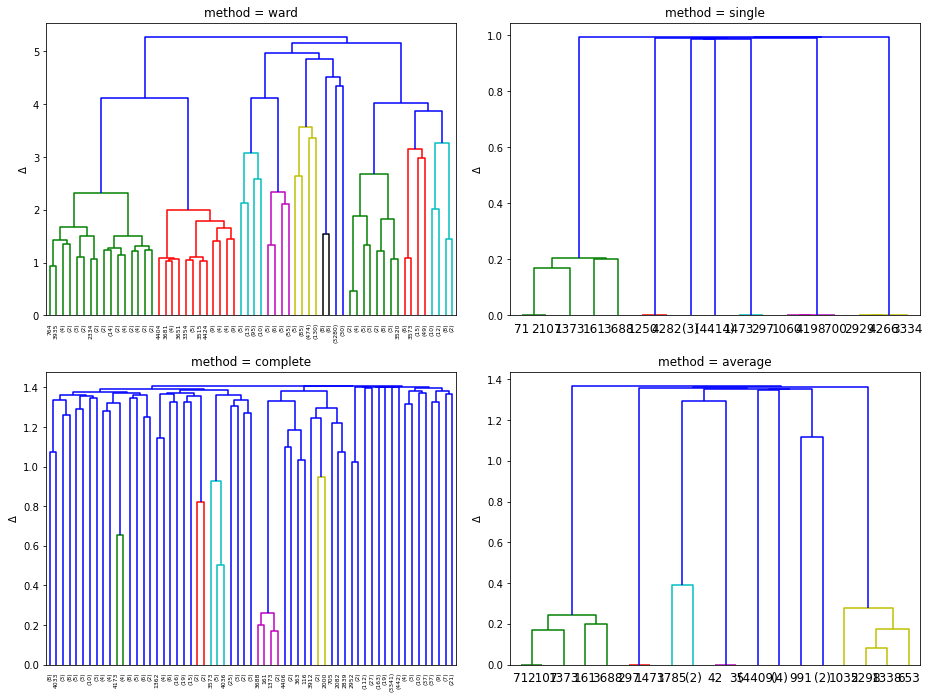

In [83]:
fig, ax = plt.subplots(
    nrows=2, ncols=2,
    constrained_layout=True,
    figsize=(12.8, 9.6))
for ax, method in zip(ax.flat, ['ward', 'single', 'complete', 'average']):
    Z = linkage(bow_message['lsa'], method=method, optimal_ordering=True)
    dn = dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_ylabel(r'$\Delta$')
    ax.set_title(f'method = {method}')

Text(0, 0.5, '$\\Delta$')

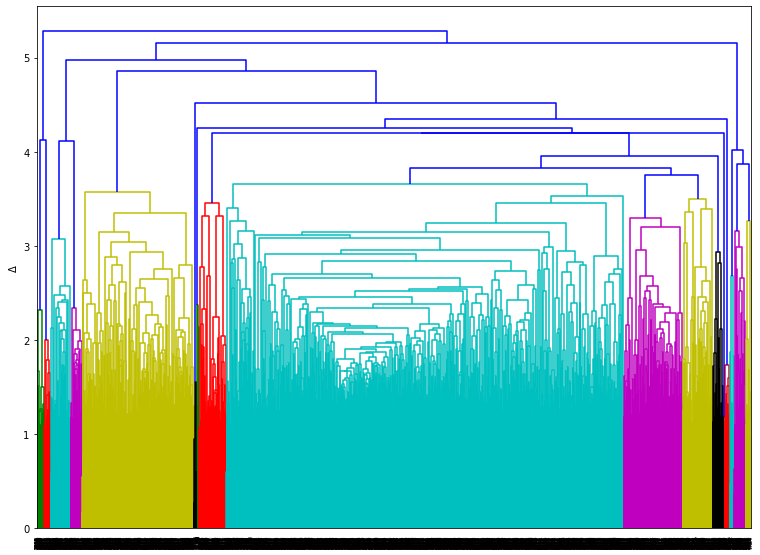

In [92]:
Z = linkage(bow_message['lsa'], method='ward', optimal_ordering=True)
fig, ax = plt.subplots(figsize=(12.8, 9.6))
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$\Delta$')
fig.show()

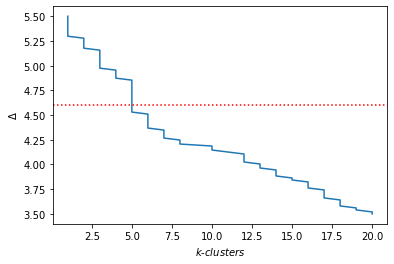

In [193]:
fig, ax = plt.subplots()
ts = np.linspace(3.5, 5.5, 100)
delta = [np.unique(fcluster(Z, t=t, criterion='distance')).size for t in ts]
ax.plot(delta, ts)
ax.axhline(4.6, ls=':', c='r')
ax.set_ylabel(r'$\Delta$')
ax.set_xlabel(r'$k$-$clusters$')
fig.show()

In [178]:
# y_predicc_message = fcluster(Z, t=4.25, criterion='distance')
y_predicc_message = fcluster(Z, t=4.60, criterion='distance')
np.unique(y_predicc_message, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int32), array([  89,  194,  694, 3324,  131]))

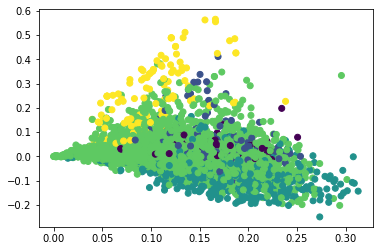

In [140]:
plt.scatter(
    bow_message['lsa'][:, 0],
    bow_message['lsa'][:, 1],
    c=y_predicc_message,
);

* Persona 1:
>May forever sa locanto<br>
Wrong tool for the job<br>
Love

* Persona 2:
>Let's get physical<br>
Physical

* Persona 3:
>Thrid one's the charm<br>
The more the merrier

* Persona 4:
>The average user<br>
The face of locanto<br>
ANG LOKO SA KANTO

* Persona 5:
>Let's take it outsude Locanto

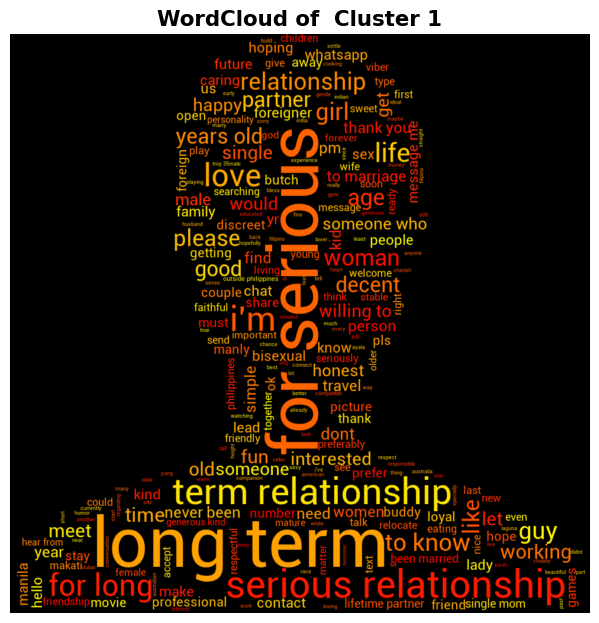

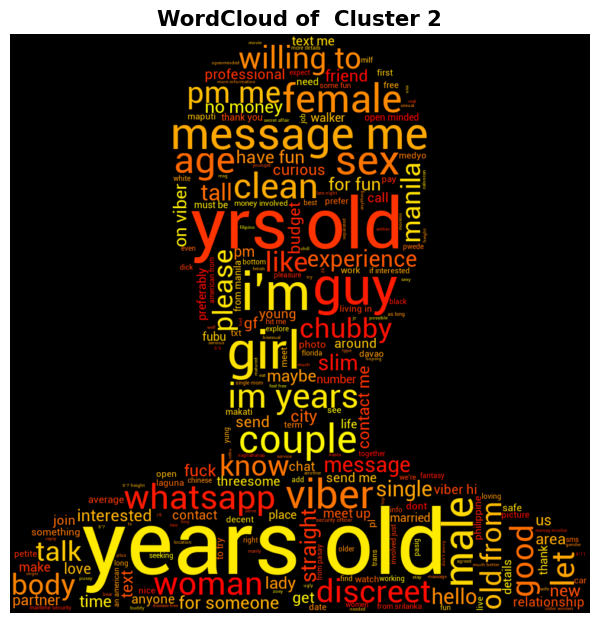

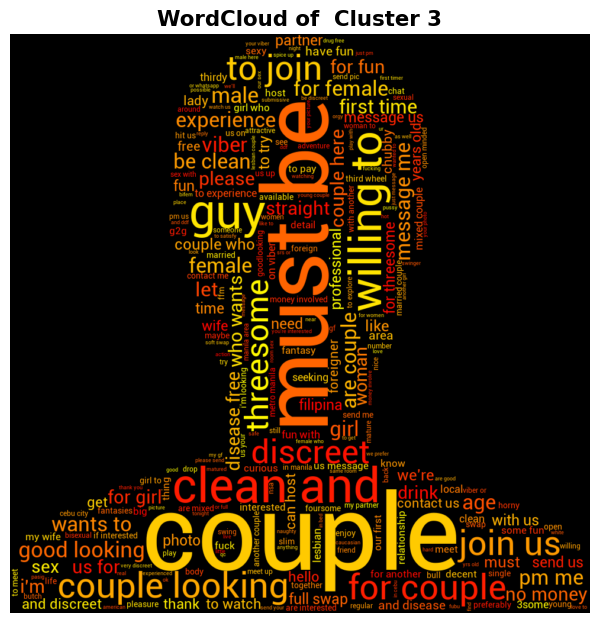

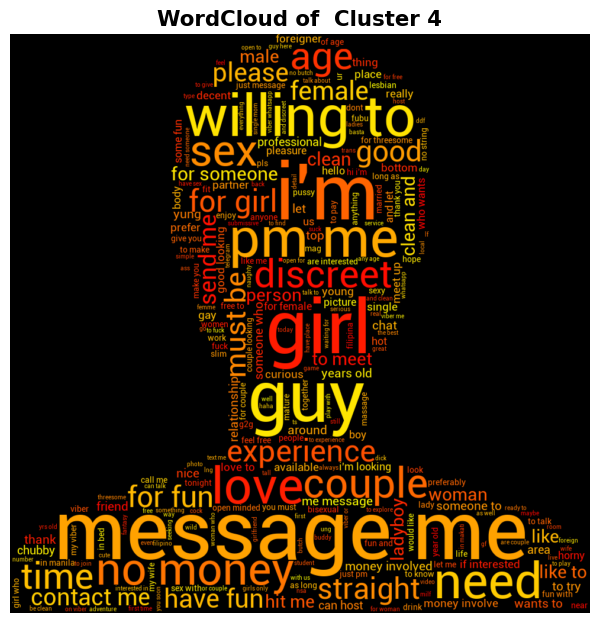

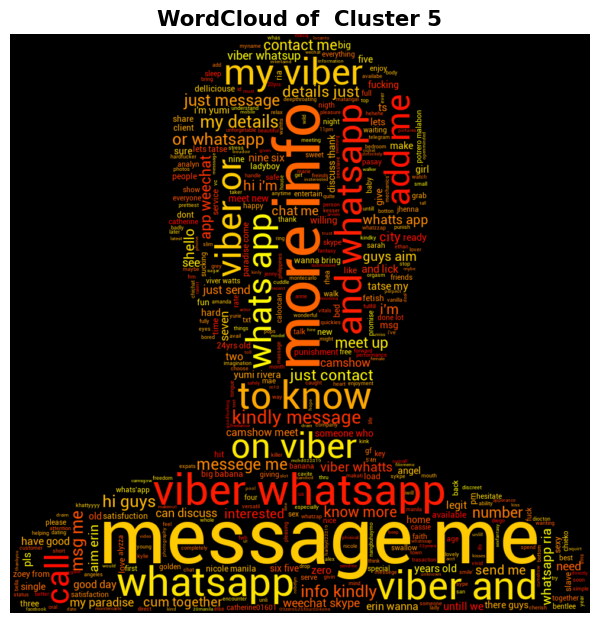

In [244]:
cluster_cloud(df_message['message'], y_predicc_message, 1337)

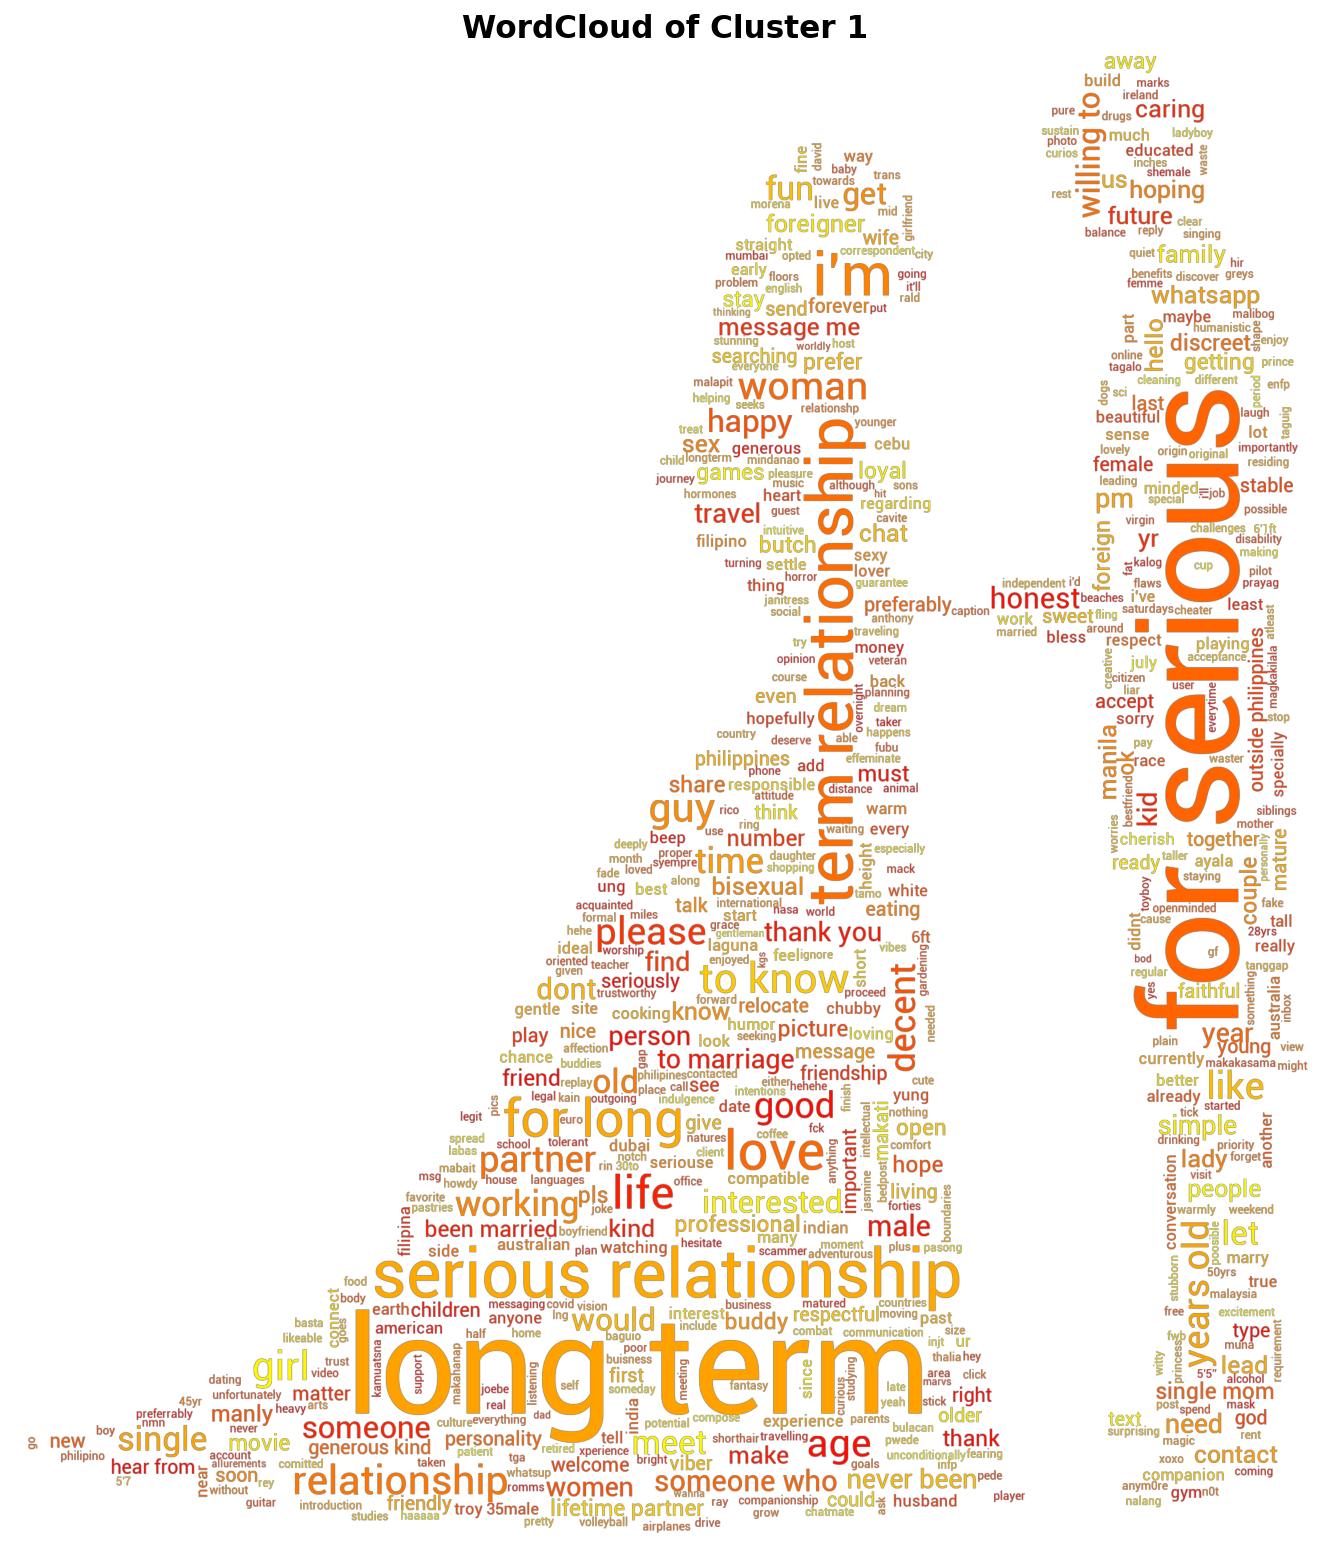

In [313]:
cluster_k_cloud(df_message['message'], y_predicc_message, 1, 'p1.png')

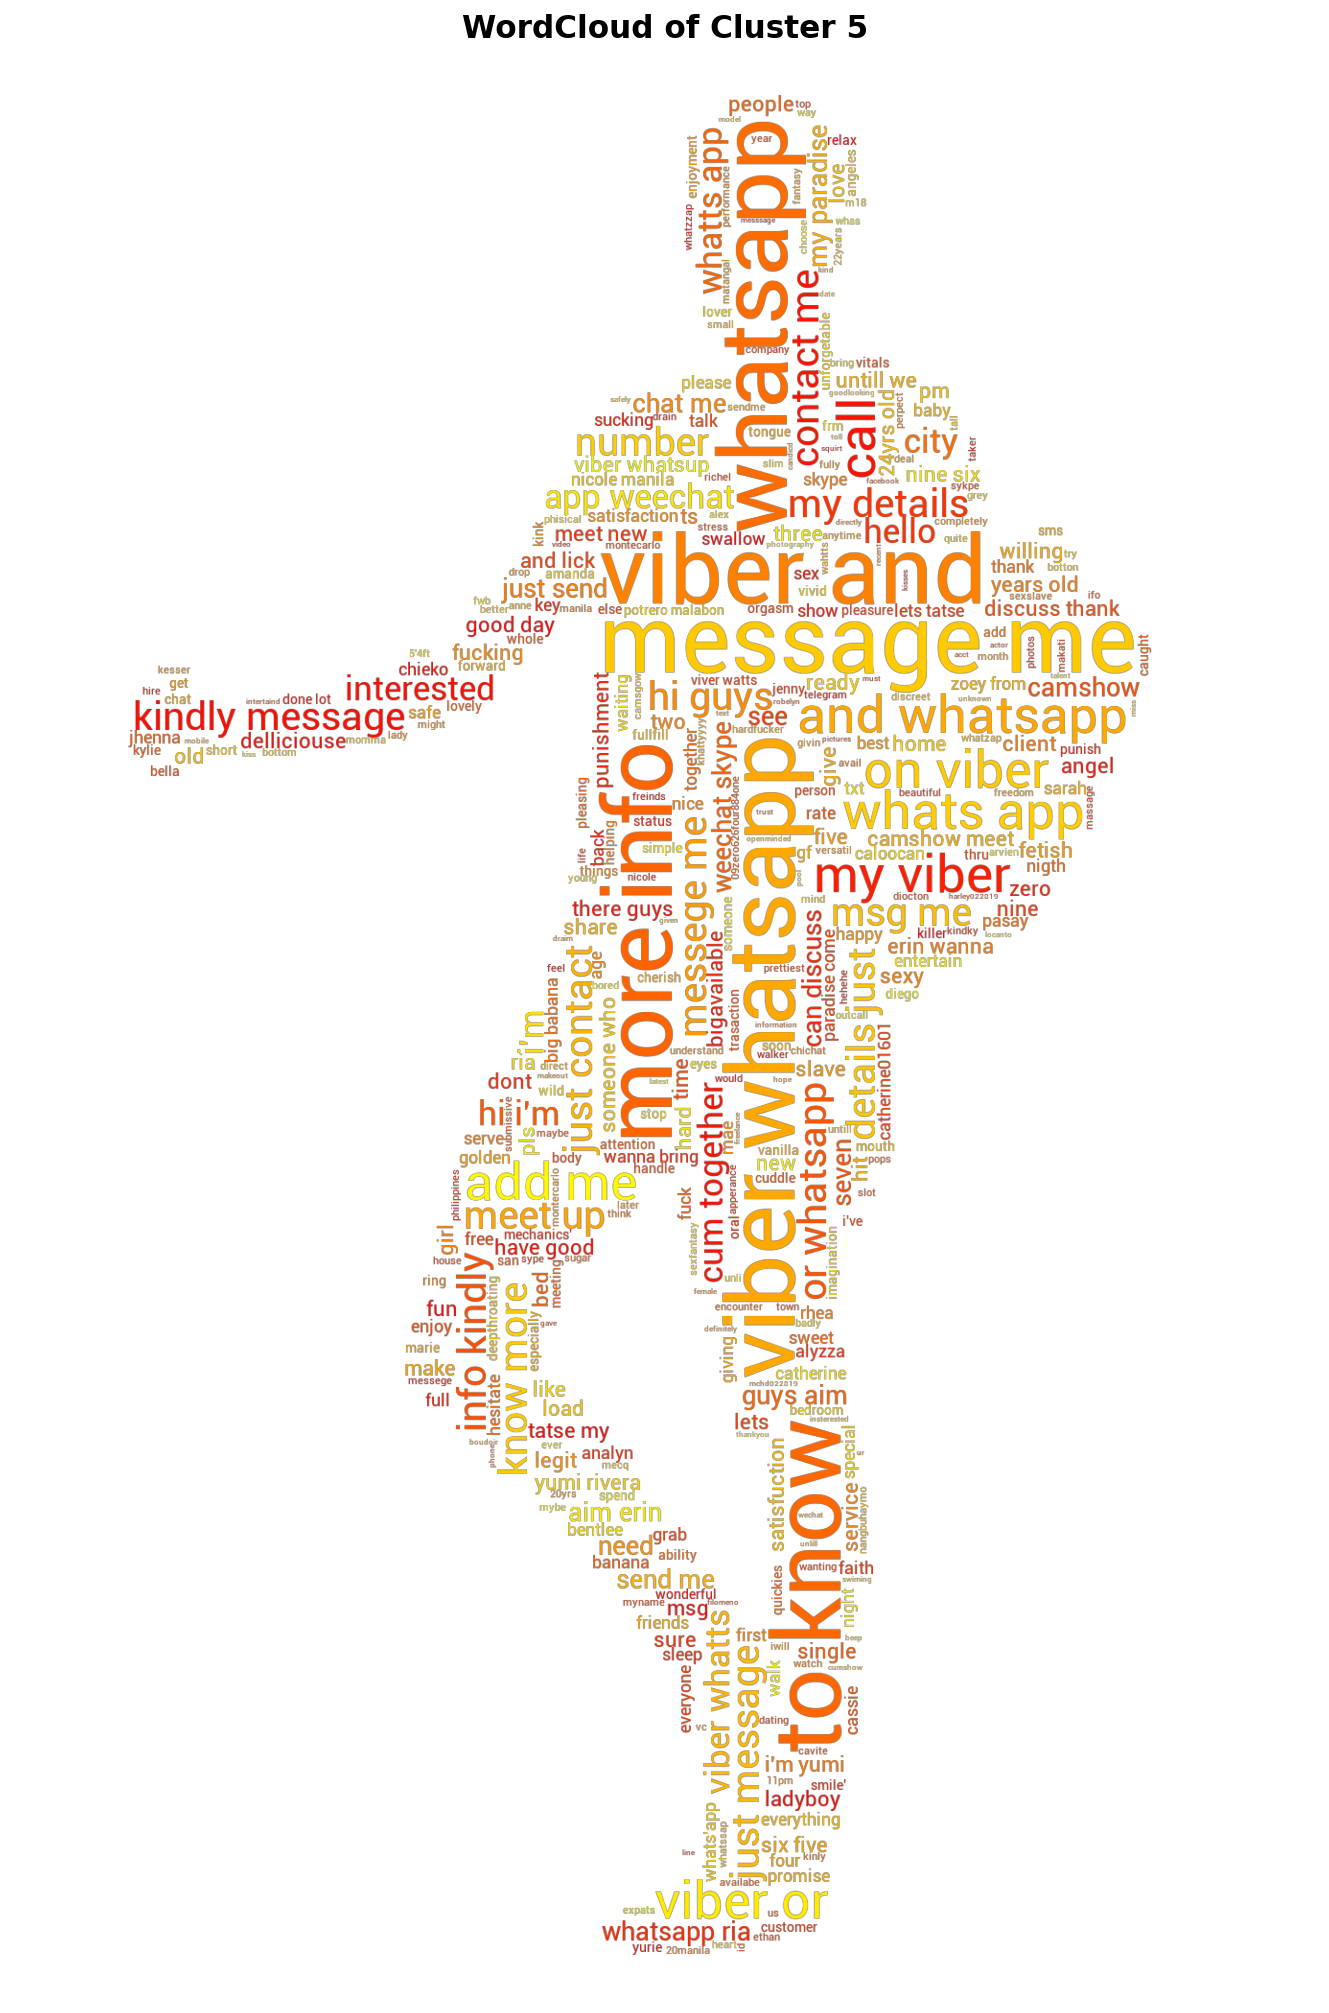

In [319]:
cluster_k_cloud(df_message['message'], y_predicc_message, 5, 'p5.jpg', rs=0)

In [194]:
test = df_message.copy()
test['description_cluster_agglo'] = y_predicc_message
test2 = df.join(test.set_index('message'), how='left', on='message')
test2.drop(columns=['index','url'], inplace=True)
test2.to_sql(
    'locanto_desc_AggloClustering',
    con=sqlite3.connect('locanto.db'),
    if_exists='replace',
    index=False)

In [403]:
with sqlite3.connect('locanto.db') as conn:
    dx = pd.read_sql('SELECT * FROM locanto_desc_AggloClustering', conn)
    display(dx)

post_id  \
0     4431741164   
1     4431741365   
2     4431741458   
3     4431741554   
4     4428795045   
...          ...   
5186  1659361528   
5187  1561193163   
5188  1371815668   
5189  1259904269   
5190  1188789296   

                                                                                                                                                                                                                                                                                                                    message  \
0                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
1                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
2                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
3                                                                                                                                                               I AM SARAH 24yrs OLD, FROM POTRERO MALABON CITY IM SINGLE AND LEGIT WALK. \n\nFOR MORE INFO AND DETAILS KINDLY MESSAGE ME. \n\nVIBER/WHATSAPP : 09666934927   
4                                                                                                                                                                                                                           looking for right now who want to chill and im on the way agad to your room? chill and netflix?   
...                                                                                                                                                                                                                                                                                                                     ...   
5186  Hi ... I am 37, my name is Ali and i am from UAE but living in manila with my filipina wife . looking for a relationship with a bbw, or a couple who is interested in swinging and swapping. RESPECT is an important factor in anybody's life so we follow that rule and expect the same from others, Any interest...   
5187  Hello we are a mixes couple American /Pilipino seeking another couple for a long term relationship. We do have requirement 1. Couple must be hygienic 2. Couple must be discreet\n3. Couple must be professional and \n4. Couple must be seeking a LTR \nIf you meet these requirements feel free to contact us. W...   
5188                                                                                                                                                                                                 No swapping of partners pero pwede touch touch , gusto lang namin ma try yung may couple din na nagsesex , taft avenue   
5189                                                                                                                                                                                                                                                                                      fuck fuck fuck fuck 3 some 4 some   
5190                                                                                                                                                                              im kurt ngo looking a couple for fun ......try me 0942 nine four seven 2020.....f

In [198]:
dx.groupby(['description_cluster_agglo', 'post_username']).apply(lambda x: (x['counts']>1).sum())

description_cluster_agglo  post_username
1                          19Light89        0
                           A1328            0
                           Ahlvin           0
                           Althea51         0
                           Angelladyboy     0
                                           ..
5                          nicolejane       0
                           ryanjust4u       0
                           solacero12       0
                           sweetchel        0
                           xerxel ish       0
Length: 3178, dtype: int64

In [236]:
search = df_title.loc[df_title['title'].str.contains(r'walker', regex=True, case=False)]
search

title  counts
16                         Blueemoon walker PASAY AREA – 23       2
168                                       Walkersnudes – 21       1
607                                     Student walker – 20       1
646                               Legit walker/camshow – 23       1
661                                 Looking for walker – 23       1
684                looking for walker, naga city bicol – 27       1
1007                           LF walker 18-25 yrs. ol – 39       1
1102         YOUR GIRL KIMMY A CHUBBY WALKER – 26 – 25 – 26       1
1122                                   Walker//camshow – 23       1
1154         LF female student walkers (19-24 yrs old) – 25       1
1213                        Looking for student walker – 24       1
1343                           Walker Sexy Girls 18-28 – 30       1
1441                    Looking for walker 8-9k budget – 29       1
1720        Available for today Anna legit walker 2020 – 25       1
1827                 Looking for walker/lady companion – 29       1
2040                       LF Walker/ 3rd Wheel - NAGA – 39       1
2082       Looking for legit walker unlipops 4k budget – 29       1
2297                    Looking for female walker – 22 – 23       1
2308                                Looking for Walker – 26       1
2392                          Look for walker (Female) – 21       1
2888  Discreet! Looking for Student walker 18+. Manila – 25       1
3126                        looking for student walker – 26       1
3349                                  Lady Walker - 25 – 24       1
3474                               Student Walker Male – 20       1
3723                   LF WALKER NA MAY SARILING PLACE – 99       1
3765                                        Lf walker! – 24       1
3849                                Looking for Walker – 23       1
3942                          Camshow//walker for hire – 23       1
4498                          Camshow/walker available – 23       1
4637      Looking for girl walker, right now – 21 – 21 – 21       1

In [237]:
msg = df.loc[df['post_title'].isin(search['title'])]
res = df_message.loc[df_message['message'].isin(msg['message'])]
res

message  \
54                                                                 Hey Gentlemen! \n\nIf youre interested kindly hit me up on whatsapp or viber 09674521690   
377                                                                                                Available walk,camshow,nudes MONUMENTO,CUBAO,PASAY ONLY.   
510                                                                                                      (0948) 262 3188 Call me or send a message on viber   
654                                                                                                  Looking for walker 8-9k budget prefer ko home check in   
757                                                                                              Hello walker here\nMsg me pasay area\n09109806915 viber us   
936                                       Looking for a Walker, MILF with Big Boobs inside Naga City, Camarines Sur. We are a Discreet Couple. PM directly.   
1576                                                Male 23 yrs old looking for walker 2k budget pantanggal stress lang meet up las pinas pm me 09307606279   
1601                   Looking for female student walkers 19-24 old\nOnly donts: bbw, trans and chubbies (no offense)\nDo pm me your dos donts and rates :)   
1613  Discreet! Looking for Student walker 18+. Manila Budget 3-6k\nPlease send picture and your school ID for fast transaction.\n\nVIBER send me a message   
1743                                                                                                    18 to 27 years old single mom much better 2k budget   
1811                          Nothing so much to do today? I'm so naughty please fuck me at your place. Drop me a message so we can start. \n\nLady Walker.   
2015                                                                                                          Hello blueemoon here pm us viber \n23 yrs old   
2051                                                     Im 24 yrs old Lf walker I like petite girl 2-3k budget, Im from alabang. Just text me\n09275720039   
2069                                                                                                                   um looking a good fuck me in my hole   
2119                                  Hello im Anna sayson\nWho's looking for camshow or walk?\nKindly pm me on my viber app to get more info 0910 246 7878   
2225                                                                                               Guy here pls send me details.. dont worry im a suretaker   
2249                                                                                                  1.5k budget. Please send photo. Message me here. Chat   
2393                                                        Looking for lady Walker every weekends. Solo lang sa condo ko. Contact me on viber 09996609826.   
2518                                                                                              Meetups only near antipolo and sta mesa\n\n2000 per 3 hrs   
2780                                                                                               Looking for a student or milf walker\nPm me. 09102156430   
2864                                                                        Near qc lang sana \nChat me your offer\nwhatsapp me bukas na agad \n09610797973   
3065                                                                              im looking for a walker, preferably slim or petite . pls. message me here   
3217                           Looking for a decent girl available now. PM me your rates including your photo if possible. Available now in Trinoma. Thanks   
3446                                                                           Ang available tomorrow please pm me price,dos and donts willing to pick u up   
3581  Looking for lady companion or Walker. Must be discreet, very discreet.... Open budget, name ur price. Young businessman here. Message me here. Thanks   
3856          

In [235]:
objects = bow_message['data']
query = objects[res.index[2], :]
queres = np.argsort([cosine(query, o) for o in objects])

/opt/conda/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [183]:
df_message.loc[queres[:10]]

message  \
710                                                           Willing to pay just viber me or whatsapp 09274260696   
1959                                                                         Im a transwoman and im willing to pay   
2205                                                        I'm willing to pay and can provide safe place. PM now.   
3645           Any female with nice armpits that are willing to allow their armpit to be licked.\n\nwilling to pay   
1366      Hi looking for a girl who can satisfy my handgag fetish and handgag me. Im willing to pay contact me now   
460                               Im Looking for butch n msarap mag massage \nWilling to pay dpende sa performance   
4042  Any couples here want to be watched? I am willing to pay just as a watcher. Patrick 36 kalookan. 09953032292   
1650                            Looking for woman for sex. Willing to pay. Send your info and price if interested.   
1906                                                                26 from cubao. 0966 334 8834 viber or WhatsApp   
1675                                    I have femine body +639127601801 viber/WhatsApp don't crossdress in public   

      counts  
710        1  
1959       1  
2205       1  
3645       1  
1366       1  
460        1  
4042       1  
1650       1  
1906       1  
1675       1

In [224]:
df_sv_cluster = pd.DataFrame(
    np.hstack((bow_message['lsa'], y_predicc_message.reshape(-1,1))),
    columns=[f'SV{i+1}'
             for i 
             in range(bow_message['lsa'].shape[1])]+['cluster']
)
display(df_sv_cluster)

SV1       SV2       SV3       SV4       SV5       SV6       SV7  \
0     0.058336  0.027565  0.018992 -0.030801  0.029727 -0.010360 -0.004551   
1     0.120475  0.022629  0.077023 -0.023683  0.026191 -0.014484  0.037610   
2     0.131628  0.354487 -0.174919 -0.019084 -0.069140  0.005962 -0.068406   
3     0.101007  0.020600  0.073097 -0.024853  0.031316 -0.002254  0.020458   
4     0.097034  0.020575  0.071794 -0.025489  0.033813 -0.003013  0.019654   
...        ...       ...       ...       ...       ...       ...       ...   
4427  0.139163 -0.026370 -0.090846 -0.076286  0.005731 -0.024741 -0.052251   
4428  0.104895  0.218117 -0.051429 -0.063775  0.000962 -0.052530 -0.030177   
4429  0.130547 -0.059638  0.023217  0.183365 -0.032919 -0.140709 -0.152554   
4430  0.133993 -0.037461  0.058770  0.170866  0.000133 -0.096216 -0.066603   
4431  0.217725 -0.031638  0.105449 -0.014957  0.034041  0.098687 -0.000731   

           SV8       SV9      SV10  ...    SV1394    SV1395    SV1396  \
0    -0.069829 -0.109066  0.006623  ... -0.013600  0.017148  0.016946   
1    -0.047635  0.071050  0.071520  ... -0.009882 -0.008558 -0.003815   
2     0.051889  0.072818  0.029484  ...  0.002802 -0.012081  0.000607   
3    -0.043204  0.090504  0.087614  ...  0.011293  0.006506 -0.004114   
4    -0.043858  0.089064  0.088840  ...  0.005089 -0.002023  0.000071   
...        ...       ...       ...  ...       ...       ...       ...   
4427 -0.009577  0.028121 -0.000538  ... -0.005963  0.011046  0.011272   
4428  0.012554 -0.082422 -0.058478  ... -0.004174 -0.008704  0.004888   
4429  0.071593 -0.001948 -0.021992  ... -0.013037  0.004654 -0.013523   
4430  0.040947  0.081049  0.006215  ...  0.003638  0.002521 -0.010690   
4431  0.005160  0.214268 -0.020673  ... -0.006211 -0.004207 -0.008730   

        SV1397    SV1398    SV1399    SV1400    SV1401    SV1402  cluster  
0     0.021267  0.009793 -0.009562  0.024731 -0.036295 -0.003846      4.0  
1    -0.000138  0.000622  0.000238 -0.004470 -0.002628  0.000105      4.0  
2    -0.004364  0.020948 -0.002342 -0.001844  0.000868 -0.009525      5.0  
3     0.000452 -0.002242 -0.007133 -0.001983 -0.004518  0.004810      4.0  
4    -0.002422  0.001714 -0.002174 -0.003791 -0.002576 -0.000276      4.0  
...        ...       ...       ...       ...       ...       ...      ...  
4427 -0.011497  0.007887  0.014060  0.009934 -0.006803  0.000017      3.0  
4428  0.013197 -0.017844 -0.009601  0.001836 -0.002989  0.012899      5.0  
4429  0.009169  0.004532  0.015082  0.023374 -0.011670  0.009779      4.0  
4430 -0.011083 -0.012432 -0.002738 -0.015653 -0.005995  0.012739      4.0  
4431 -0.008267  0.001355  0.003717 -0.011713 -0.000579 -0.010430      4.0  

[4432 rows x 1403 columns]

In [ ]:
ax = sns.catplot(
    x='cluster',
    y='SV14',
    data=df_sv_cluster,
    kind='bar',
    estimator=np.mean
)

In [212]:
bow_message['lsa'].shape[1]

1402

In [404]:
dx.groupby('description_cluster_agglo').size()/len(df)

description_cluster_agglo
1    0.017145
2    0.038721
3    0.144096
4    0.757080
5    0.042959
dtype: float64

## Titles

In [ ]:
bow_title['lsa']